### This version cleaned and without validation (only 1 epoch, so don't use validation) 

In [1]:
import warnings
warnings.filterwarnings('ignore') # to suppress some matplotlib deprecation warnings

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import ast
import cv2

import matplotlib.pyplot as plt
import matplotlib.style as style

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import glob
import time
import tqdm

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import torchvision
from torchvision import transforms, utils

In [3]:
en_dict = {}
path = './doodle_dataset/train_simplified'# 数据集存储位置

filenames = glob.glob(os.path.join(path, '*.csv')) 
filenames = sorted(filenames)# 获得所有类似后缀并排序

def encode_files():
    """ Encode all label by name of csv_files """
    counter = 0
    for fn in filenames:
        en_dict[fn[:-4].split('\\')[-1].replace(' ', '_')] = counter # 剪切掉只留下有用字符
        counter += 1
    print(counter)
        
# collect file names and encode label
encode_files() 

dec_dict = {v: k for k, v in en_dict.items()} # dict互换位置
def decode_labels(label):
    return dec_dict[label] # 通过数字获得名称

def get_label(nfile):
    """ Return encoded label for class by name of csv_files """
    return en_dict[nfile.replace(' ', '_')[:-4]]

340


## Dataset class and loader
Another example on official  [tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

### Load data to our DoodlesDataset

In [4]:
class DoodlesDataset(Dataset):
    """Doodles csv dataset."""

    def __init__(self, csv_file, root_dir, mode='train', nrows=1000, skiprows=None, size=256, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            mode (string): Train or test mode.
            nrows (int): Number of rows of file to read. Useful for reading pieces of large files.
            skiprows (list-like or integer or callable): 
                    Line numbers to skip (0-indexed) or number of lines to skip (int) at the start of the file.
            size (int): Size of output image.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        file = os.path.join(self.root_dir, csv_file)
        self.size = size
        self.mode = mode
        self.doodle = pd.read_csv(file, usecols=['drawing'], nrows=nrows, skiprows=skiprows)
        self.transform = transform
        if self.mode == 'train':
            self.label = get_label(csv_file)

    @staticmethod
    def _draw(raw_strokes, size=256, lw=6, time_color=True):
        BASE_SIZE = 256
        img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
        for t, stroke in enumerate(raw_strokes):
            for i in range(len(stroke[0]) - 1):
                color = 255 - min(t, 10) * 13 if time_color else 255
                _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                             (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
        if size != BASE_SIZE:
            return cv2.resize(img, (size, size))
        else:
            return img
    
    def __len__(self):
        return len(self.doodle)

    def __getitem__(self, idx):
        raw_strokes = ast.literal_eval(self.doodle.drawing[idx])
        sample = self._draw(raw_strokes, size=self.size, lw=2, time_color=True)
        if self.transform:
            sample = self.transform(sample)
        if self.mode == 'train':
            return (sample[None]/255).astype('float32'), self.label
        else:
            return (sample[None]/255).astype('float32')

In [5]:
SIZE = 224 # for matching to imagenet
# collect all single csvset in one
select_nrows = 4000
doodles = ConcatDataset([DoodlesDataset(fn.split('\\')[-1], path, 
                                           nrows=select_nrows, size=SIZE) for fn in filenames])


In [6]:
doodlesTest = ConcatDataset([DoodlesDataset(fn.split('\\')[-1], path, 
                                            nrows=30, skiprows=lambda x: (x < 4000) & (x > 1), size=SIZE) for fn in filenames])
# a = pd.read_csv(filenames[0], usecols=['drawing'], nrows=20, skiprows=lambda x: (x < 4000) & (x > 1))

In [7]:
# total images in set
print('Train set:', len(doodles))
print('Train set:', len(doodlesTest))
# print('Validation set:', len(validationset))
# Use the torch dataloader to iterate through the dataset
loader = DataLoader(doodles, batch_size=32, shuffle=True, num_workers=0)
testloader = DataLoader(doodlesTest, batch_size=32, shuffle=True, num_workers=0)
# valid_loader = DataLoader(validationset, batch_size=128, shuffle=False, num_workers=0)

Train set: 1360000
Train set: 10200


In [8]:
# functions to show an image and test
def imshow(img):
    npimg = img.numpy() # 转化为ndarry
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


### Get some images from set

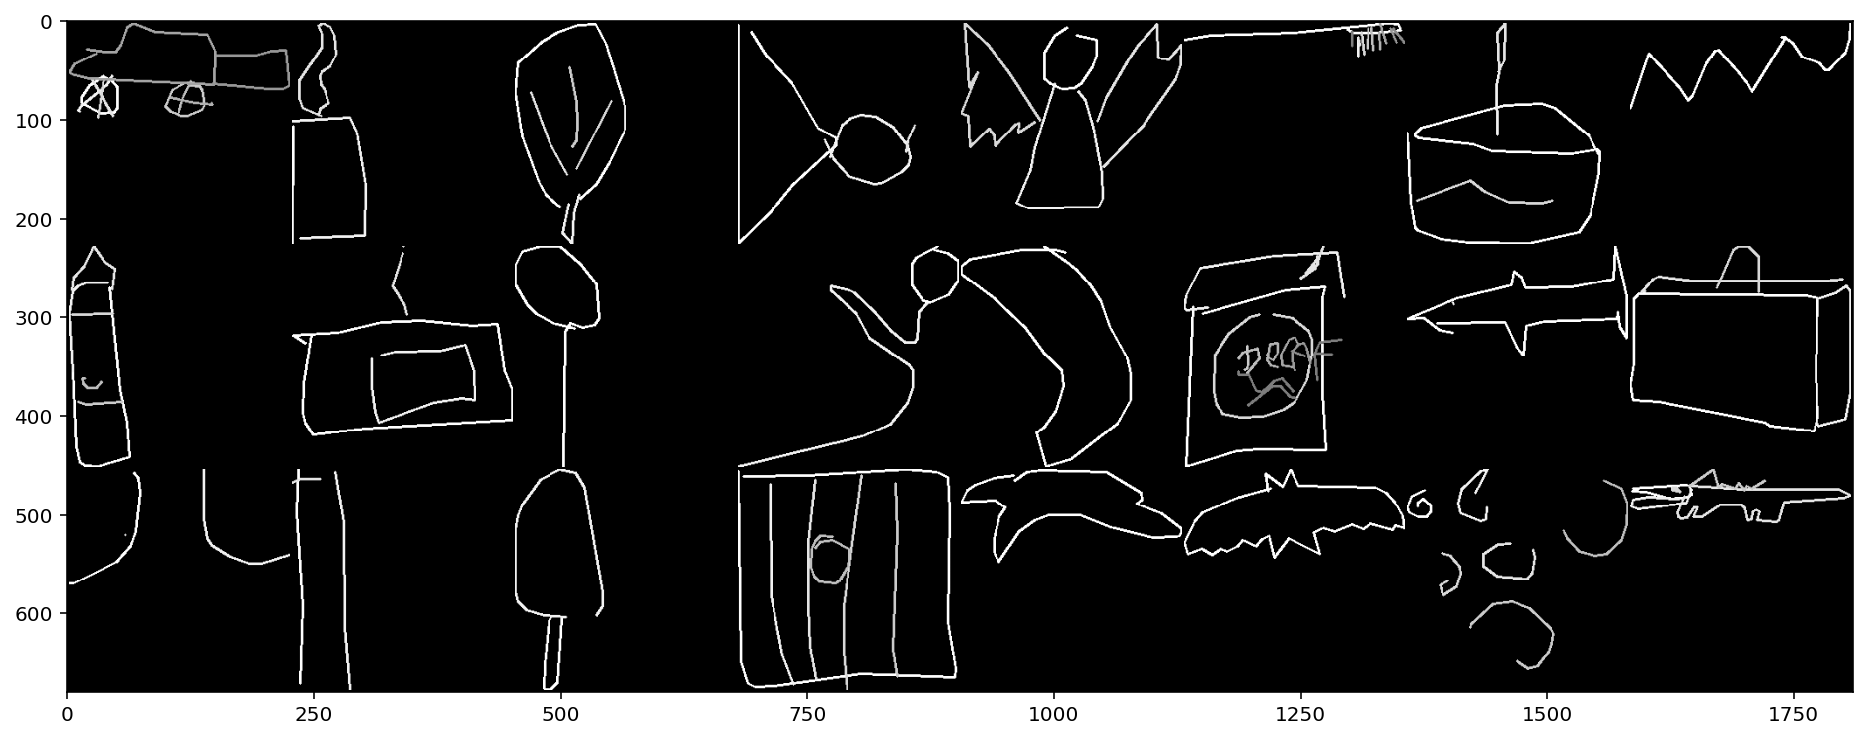

In [14]:

# get some images
dataiter = iter(loader)
images, label = dataiter.next()

# show images
plt.figure(figsize=(16,24)) # 每次显示16*24的图（这样一行可以显示8个）
imshow(torchvision.utils.make_grid(images[:24])) # 显示前24张图

NameError: name 'device' is not defined

In [49]:
# print(" % d" % index for index in range(len(pred[i]) index].item())
# print(4)
# print('%5d' % j for j in range(24))
# print(' '.join('%5d' % index for index in range(3) if label[4].item() == pred[4][index].item()))
# print(decode_labels(label[4].item()))
# print(decode_labels(pred[4][1].item()))
# del pred,images,label
torch.cuda.empty_cache()

In [9]:
# validation function 
def validation(lossf, scoref):
    model.eval()
    loss, score = 0, 0
    vlen = len(loader)
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss += lossf(output, y).item()
        score += scoref(output, y)[0].item()
    model.train()
    return loss/vlen, score/vlen

### Define metric finction

In [9]:
def mapk(output, target, k=3):
    """
    Computes the mean average precision at k.
    
    Parameters
    ----------
    output (torch.Tensor): A Tensor of predicted elements.
                           Shape: (N,C)  where C = number of classes, N = batch size
    target (torch.int): A Tensor of elements that are to be predicted. 
                        Shape: (N) where each value is  0≤targets[i]≤C−1
    k (int, optional): The maximum number of predicted elements
    
    Returns
    -------
    score (torch.float):  The mean average precision at k over the output
    """
    with torch.no_grad():
        batch_size = target.size(0)

        _, pred = output.topk(k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        for i in range(k):
            correct[i] = correct[i]*(k-i)
            
        score = correct[:k].view(-1).float().sum(0, keepdim=True)
        score.mul_(1.0 / (k * batch_size))
        return score

### Create model. Loading pretrained version.

In [22]:
# dir(torchvision.models)
model = torchvision.models.vgg11()
print(model.parameters)

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fal

In [9]:
model = torchvision.models.vgg11(pretrained = True)
def squeeze_weights(m):
    m.weight.data = m.weight.data.sum(dim=1)[:,None]
    m.in_channels = 1
model.features[0].apply(squeeze_weights)

num_classes = 340
model.classifier[6] = nn.Linear(in_features=4096, out_features=340, bias=True)

# model = torchvision.models.squeezenet1_0(pretrained = True)
# def squeeze_weights(m):
#     m.weight.data = m.weight.data.sum(dim=1)[:,None]
#     m.in_channels = 1
# model.features[0].apply(squeeze_weights)
# num_classes = 340
# model.classifier[1] = nn.Conv2d(512, num_classes, (1, 1), (1, 1))

# model = torchvision.models.resnet34(pretrained = True)
# def squeeze_weights(m):
#     m.weight.data = m.weight.data.sum(dim=1)[:,None]
#     m.in_channels = 1
# model.conv1.apply(squeeze_weights)
# num_classes = 340
# model.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)



In [10]:
# Load  net

loadModel = torch.load(os.path.join('./', 'checkpoint_vgg11_SVD.pth'))
# print(model.parameters)
model.load_state_dict(loadModel)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

Change number of inputs channels and number of classes. Details about model and code [here](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py)

In [16]:
# print(model.parameters)
# dir(model)

Test model using random number. Just checking for service.

In [42]:
%%time
# test with random data
model(torch.randn(12,1,224,224)).size()
print(model(torch.randn(12,1,224,224)))

tensor([[ 0.6572,  1.2911,  0.3821,  ..., -0.2323, -0.2634,  0.4193],
        [-0.0289,  0.5510, -0.1026,  ...,  0.1889, -0.1723, -0.3851],
        [-0.2829,  0.1223,  0.1129,  ...,  0.2096, -0.0627,  0.1810],
        ...,
        [ 0.2697,  0.9035, -0.2407,  ...,  0.2567,  0.5287, -0.0471],
        [ 0.2975,  1.2920, -0.4543,  ...,  0.1436, -0.3550,  0.2594],
        [ 0.3144,  0.5873, -0.2508,  ...,  0.7806,  0.3827,  0.6589]],
       grad_fn=<AddmmBackward>)
Wall time: 1.97 s


In [11]:
device = 'cuda'
model.to(device);
# torch.cuda.set_device(1)

In [12]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad=True)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0002, momentum=0.9);
# optimizer = torch.optim.Adam(model.parameters(), lr=0.002, betas=(0.9, 0.99))

In [13]:
# PyTorch scheduler:
# https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5000,12000,18000], gamma=0.5)
# scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

In [19]:
torch.cuda.empty_cache()

Training loop with printing information every 1000 iteration

In [46]:
%%time
epochs = 1
lsize = len(loader)
itr = 1
p_itr = 20 # print every N iteration
model.train()
tloss, score = 0, 0
for epoch in range(epochs):
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        tloss += loss.item()
        score += mapk(output, y)[0].item()
        scheduler.step()
        if itr%p_itr==0:
            print('Iteration {} -> Train Loss: {:.4f}, MAP@3: {:.3f}'.format(itr, tloss/p_itr, score/p_itr))
            tloss, score = 0, 0
        itr +=1

Iteration 20 -> Train Loss: 5.9060, MAP@3: 0.005
Iteration 40 -> Train Loss: 5.8760, MAP@3: 0.002
Iteration 60 -> Train Loss: 5.8446, MAP@3: 0.010
Iteration 80 -> Train Loss: 5.8536, MAP@3: 0.010
Iteration 100 -> Train Loss: 5.8322, MAP@3: 0.008
Iteration 120 -> Train Loss: 5.8396, MAP@3: 0.008
Iteration 140 -> Train Loss: 5.8329, MAP@3: 0.010
Iteration 160 -> Train Loss: 5.8340, MAP@3: 0.007
Iteration 180 -> Train Loss: 5.8164, MAP@3: 0.011
Iteration 200 -> Train Loss: 5.7997, MAP@3: 0.010
Iteration 220 -> Train Loss: 5.8137, MAP@3: 0.010
Iteration 240 -> Train Loss: 5.8158, MAP@3: 0.010
Iteration 260 -> Train Loss: 5.7984, MAP@3: 0.017
Iteration 280 -> Train Loss: 5.7975, MAP@3: 0.014
Iteration 300 -> Train Loss: 5.7855, MAP@3: 0.014
Iteration 320 -> Train Loss: 5.7884, MAP@3: 0.015
Iteration 340 -> Train Loss: 5.7947, MAP@3: 0.008
Iteration 360 -> Train Loss: 5.7823, MAP@3: 0.014
Iteration 380 -> Train Loss: 5.7915, MAP@3: 0.016
Iteration 400 -> Train Loss: 5.7601, MAP@3: 0.015
Iter

Iteration 3240 -> Train Loss: 2.5550, MAP@3: 0.521
Iteration 3260 -> Train Loss: 2.4942, MAP@3: 0.530
Iteration 3280 -> Train Loss: 2.5107, MAP@3: 0.547
Iteration 3300 -> Train Loss: 2.4838, MAP@3: 0.535
Iteration 3320 -> Train Loss: 2.5877, MAP@3: 0.524
Iteration 3340 -> Train Loss: 2.4232, MAP@3: 0.561
Iteration 3360 -> Train Loss: 2.4090, MAP@3: 0.549
Iteration 3380 -> Train Loss: 2.5110, MAP@3: 0.531
Iteration 3400 -> Train Loss: 2.5015, MAP@3: 0.533
Iteration 3420 -> Train Loss: 2.4339, MAP@3: 0.538
Iteration 3440 -> Train Loss: 2.4634, MAP@3: 0.542
Iteration 3460 -> Train Loss: 2.4584, MAP@3: 0.540
Iteration 3480 -> Train Loss: 2.4020, MAP@3: 0.551
Iteration 3500 -> Train Loss: 2.3680, MAP@3: 0.556
Iteration 3520 -> Train Loss: 2.4159, MAP@3: 0.559
Iteration 3540 -> Train Loss: 2.5031, MAP@3: 0.535
Iteration 3560 -> Train Loss: 2.4180, MAP@3: 0.552
Iteration 3580 -> Train Loss: 2.4764, MAP@3: 0.543
Iteration 3600 -> Train Loss: 2.3609, MAP@3: 0.578
Iteration 3620 -> Train Loss: 2

Iteration 6440 -> Train Loss: 1.9751, MAP@3: 0.634
Iteration 6460 -> Train Loss: 2.0833, MAP@3: 0.619
Iteration 6480 -> Train Loss: 2.0190, MAP@3: 0.621
Iteration 6500 -> Train Loss: 1.9956, MAP@3: 0.623
Iteration 6520 -> Train Loss: 2.0316, MAP@3: 0.625
Iteration 6540 -> Train Loss: 2.0463, MAP@3: 0.621
Iteration 6560 -> Train Loss: 2.0810, MAP@3: 0.607
Iteration 6580 -> Train Loss: 2.0986, MAP@3: 0.630
Iteration 6600 -> Train Loss: 2.0505, MAP@3: 0.629
Iteration 6620 -> Train Loss: 2.1437, MAP@3: 0.609
Iteration 6640 -> Train Loss: 2.0398, MAP@3: 0.625
Iteration 6660 -> Train Loss: 1.9409, MAP@3: 0.654
Iteration 6680 -> Train Loss: 2.0060, MAP@3: 0.637
Iteration 6700 -> Train Loss: 2.0101, MAP@3: 0.643
Iteration 6720 -> Train Loss: 2.0384, MAP@3: 0.621
Iteration 6740 -> Train Loss: 2.1154, MAP@3: 0.623
Iteration 6760 -> Train Loss: 2.0579, MAP@3: 0.626
Iteration 6780 -> Train Loss: 1.9992, MAP@3: 0.641
Iteration 6800 -> Train Loss: 2.0445, MAP@3: 0.625
Iteration 6820 -> Train Loss: 2

Iteration 9640 -> Train Loss: 1.9525, MAP@3: 0.659
Iteration 9660 -> Train Loss: 1.8323, MAP@3: 0.665
Iteration 9680 -> Train Loss: 1.9533, MAP@3: 0.654
Iteration 9700 -> Train Loss: 2.0230, MAP@3: 0.637
Iteration 9720 -> Train Loss: 1.9043, MAP@3: 0.655
Iteration 9740 -> Train Loss: 1.8139, MAP@3: 0.675
Iteration 9760 -> Train Loss: 1.7938, MAP@3: 0.681
Iteration 9780 -> Train Loss: 1.9184, MAP@3: 0.648
Iteration 9800 -> Train Loss: 1.8743, MAP@3: 0.658
Iteration 9820 -> Train Loss: 1.9397, MAP@3: 0.647
Iteration 9840 -> Train Loss: 1.8834, MAP@3: 0.664
Iteration 9860 -> Train Loss: 1.7319, MAP@3: 0.692
Iteration 9880 -> Train Loss: 1.8070, MAP@3: 0.672
Iteration 9900 -> Train Loss: 1.8242, MAP@3: 0.652
Iteration 9920 -> Train Loss: 1.9725, MAP@3: 0.646
Iteration 9940 -> Train Loss: 1.9459, MAP@3: 0.651
Iteration 9960 -> Train Loss: 1.9462, MAP@3: 0.655
Iteration 9980 -> Train Loss: 1.8849, MAP@3: 0.655
Iteration 10000 -> Train Loss: 2.0300, MAP@3: 0.629
Iteration 10020 -> Train Loss:

KeyboardInterrupt: 

### Save model state

In [47]:
filename_pth='checkpoint_vgg11_SVD.pth'
torch.save(model.state_dict(), filename_pth)


### And finally predict for test set 

In [14]:
# testset = DoodlesDataset('test_simplified.csv', './quickdraw-doodle-recognition', mode='test', nrows=None, size=SIZE)
# testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)
# model.eval()
# itrs = iter(loader)
# x,y = itrs.next()
# print(x)
# testLoader test show
def testfun(m):
    dataiter = iter(testloader)
    torch.cuda.empty_cache()
    images, label = dataiter.next()
    images, label = images.to(device), label.to(device)
    out = model(images)

    _, pred = out.topk(3, 1, True, True)
    pred = pred.cpu()
    images = images.cpu()
    label = label.cpu()
    correct = 0
    total = 0
    for i in range(pred.size()[0]):
        print('Guess:',' '.join('[%20s]' % decode_labels(j.item()) for j in pred[i]),'||||||Expected [%20s]' % decode_labels(label[i].item()))
        if label[i] in pred[i]:
            correct = correct+1
            # print(' '.join('GoodDick! The %15d one is right answer.' % index for index in range(3) if label[i].item() == pred[i][index].item()))
        else:
            print('Ben dan ,Guess failed!')
        total = total+1

    # print(' '.join('%5s' % decode_labels(label.numpy()[j]) for j in range(24)))
    print(' Totally %d test images, right %d images, accuracy %d %%' % (total,correct,
        100 * correct / total))
    # show images
    plt.figure(figsize=(16,16))

    imshow(torchvision.utils.make_grid(images[:64]))


In [ ]:
def calcu():
    model.eval()
    labels = np.empty((0,3))
    answer = []
    for x,y in tqdm.tqdm(testloader):
        x = x.to(device)
        output = model(x)
        _, pred = output.topk(3, 1, True, True)
        pred = pred.cpu()
        labels = np.concatenate([labels, pred], axis = 0)
        answer.extend(y.numpy())
    correct = 0
    total = 0
    with torch.no_grad():
        for i, lab in enumerate(answer):
            if lab in labels[i]:
                # print(labels[i])
                correct = correct+1
            total = total+1
    print('Accuracy of the network on the %d test images: %d %%' % (total,
        100 * correct / total))

In [40]:
del model

In [ ]:
%%time
submission = pd.read_csv('./doodle_dataset/test_simplified.csv', index_col='key_id')
submission.drop(['countrycode', 'drawing'], axis=1, inplace=True)
submission['word'] = ''
for i, label in enumerate(labels):
    submission.word.iloc[i] = " ".join([decode_labels(l) for l in label])

In [ ]:
submission.to_csv('preds_resnet18.csv')

In [165]:
print(accuracy(torch.from_numpy(labels),torch.from_numpy(answer)))

TypeError: expected np.ndarray (got list)

In [20]:
testfun(0)

RuntimeError: CUDA out of memory. Tried to allocate 784.00 MiB (GPU 0; 8.00 GiB total capacity; 5.89 GiB already allocated; 153.75 MiB free; 198.68 MiB cached)

In [16]:
calcu()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319/319 [00:28<00:00, 11.37it/s]


Accuracy of the network on the 10200 test images: 81 %
